In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Gene-level TPM checking

In [ ]:
gene_data_K562 = pd.read_csv('/nfs/data/IHEC/RNAseq/RNA-Seq/ihec.rna-seq.ihec-grapenf-containerv1.1.0.IHECRE00001887.4.b2b4ded3-20fb-4626-b1c9-2afcd18bd6ec.genes.results', sep="\t")
gene_data_GM12878 = pd.read_csv('/nfs/data/IHEC/RNAseq/RNA-Seq/ihec.rna-seq.ihec-grapenf-containerv1.1.0.IHECRE00001892.5.c5893651-dcc4-47b1-a647-a853e04e006d.genes.results', sep="\t")

# sanity check
print(f"Summed expression values for K562: {gene_data_K562['TPM'].sum()}")
print(f"Summed expression values for GM12878: {gene_data_GM12878['TPM'].sum()}")

gene_data_GM12878['gene_id'] = gene_data_GM12878['gene_id'].str.split('.').str[0]
gene_data_K562['gene_id'] = gene_data_K562['gene_id'].str.split('.').str[0]

Summed expression values for K562: 999998.9000000001
Summed expression values for GM12878: 999999.2100000001


In [3]:
# get Xpresso TPM values
xpresso_K562 = pd.read_csv('data/GM12878_K562_18377_gene_expr_fromXpresso.csv', sep=",")
xpresso_GM12878 = pd.read_csv('data/GM12878_K562_18377_gene_expr_fromXpresso.csv', sep=",")

# filter gene data by gene names present in xpresso data and check their summed TPM
gene_data_K562_filtered = gene_data_K562[gene_data_K562['gene_id'].isin(xpresso_K562['Name'])].copy()
gene_data_GM12878_filtered = gene_data_GM12878[gene_data_GM12878['gene_id'].isin(xpresso_GM12878['Name'])].copy()
print(f"Length of filtered K562 data: {len(gene_data_K562_filtered)} and GM12878 data: {len(gene_data_GM12878_filtered)}")

gene_data_K562_filtered['logTPM'] = np.log10(gene_data_K562_filtered['TPM'] + 0.1)
gene_data_GM12878_filtered['logTPM'] = np.log10(gene_data_GM12878_filtered['TPM'] + 0.1)
# mean center the logTPM values
gene_data_K562_filtered['logTPM_centered'] = gene_data_K562_filtered['logTPM'] - gene_data_K562_filtered['logTPM'].mean()
gene_data_GM12878_filtered['logTPM_centered'] = gene_data_GM12878_filtered['logTPM'] - gene_data_GM12878_filtered['logTPM'].mean()

k562_mean_shift = gene_data_K562_filtered['logTPM'].mean() - xpresso_K562['Actual_K562'].mean()
gm12878_mean_shift = gene_data_GM12878_filtered['logTPM'].mean() - xpresso_GM12878['Actual_GM12878'].mean()
xpresso_K562['TPM'] = (10**(xpresso_K562['Actual_K562'] + k562_mean_shift)) - 0.1
xpresso_GM12878['TPM'] = (10**xpresso_GM12878['Actual_GM12878'] + gm12878_mean_shift) - 0.1

print(f"Summed expression values for K562 from Xpresso: {xpresso_K562['TPM'].sum()} vs. ours {gene_data_K562_filtered['TPM'].sum()}")
print(f"Summed expression values for GM12878 from Xpresso: {xpresso_GM12878['TPM'].sum()} vs. ours {gene_data_GM12878_filtered['TPM'].sum()}")


print(f"Max logTPM for K562: {gene_data_K562_filtered['logTPM_centered'].max()} vs {xpresso_K562['Actual_K562'].max()}")
#print(f"Max logTPM for GM12878: {gene_data_GM12878_filtered['logTPM'].max()} vs {xpresso_GM12878['Actual_GM12878'].max()}")
print(f"Percent values greater than 0 for K562: {np.sum(gene_data_K562_filtered['logTPM_centered'] > 0) / len(gene_data_K562_filtered)} vs " \
      f"{np.sum(xpresso_K562['Actual_K562'] > 0) / len(xpresso_K562)}")

print(f"Expression on subset for K562: {gene_data_K562_filtered['logTPM_centered'].sum()} vs. {xpresso_K562['Actual_K562'].sum()}")
print(f"Expression mean for K562: {gene_data_K562_filtered['logTPM_centered'].mean()} vs. {xpresso_K562['Actual_K562'].mean()}")
#print(f"Expression on subset for GM12878: {gene_data_GM12878_filtered['logTPM'].sum()} vs. {xpresso_GM12878['Actual_GM12878'].sum()}")

Length of filtered K562 data: 18378 and GM12878 data: 18378
Summed expression values for K562 from Xpresso: 336291.21872238285 vs. ours 582995.7300000001
Summed expression values for GM12878 from Xpresso: 151685.1619453938 vs. ours 557859.0099999999
Max logTPM for K562: 3.817631216838529 vs 3.585388929
Percent values greater than 0 for K562: 0.5200239416693873 vs 0.5193992490613266
Expression on subset for K562: -3.410605131648481e-13 vs. 2.1293544705258682e-10
Expression mean for K562: -1.855808647104408e-17 vs. 1.1587062472252643e-14


<Figure size 600x600 with 0 Axes>

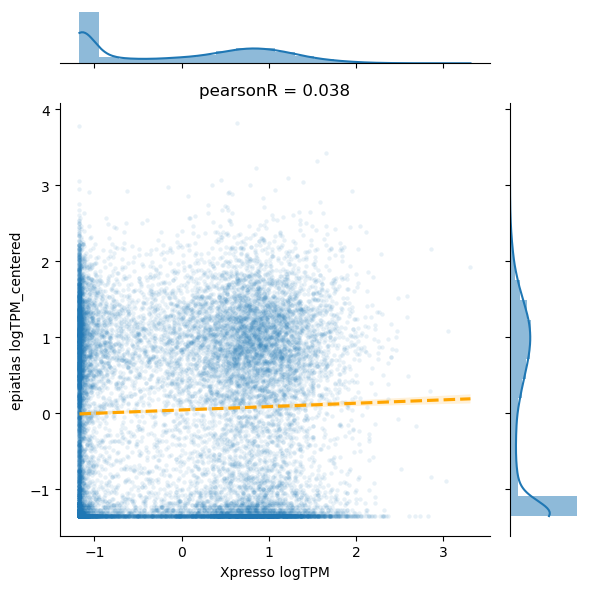

In [41]:
gene_data_k562_combined = pd.DataFrame({
    'gene_id': gene_data_K562_filtered['gene_id'],
    'epiatlas': gene_data_K562_filtered['logTPM_centered'],
    'xpresso': xpresso_K562['Actual_K562']
})
gene_data_k562_combined = gene_data_k562_combined.dropna()

pearson_r = stats.pearsonr(gene_data_k562_combined['epiatlas'], gene_data_k562_combined['xpresso'])
plt.figure(figsize=(6,6))
ax = sns.jointplot(
    data=gene_data_k562_combined,
    x="xpresso",
    y="epiatlas",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearson_r.statistic))
plt.ylabel('epiatlas logTPM_centered')
plt.xlabel('Xpresso logTPM')
plt.tight_layout()

## Transcript-level PSI check

In [50]:
transcript_data_K562 = pd.read_csv('/nfs/data/IHEC/RNAseq/RNA-Seq/ihec.rna-seq.ihec-grapenf-containerv1.1.0.IHECRE00001887.4.b2b4ded3-20fb-4626-b1c9-2afcd18bd6ec.isoforms.results', sep="\t")
transcript_data_GM12878 = pd.read_csv('/nfs/data/IHEC/RNAseq/RNA-Seq/ihec.rna-seq.ihec-grapenf-containerv1.1.0.IHECRE00001892.5.c5893651-dcc4-47b1-a647-a853e04e006d.isoforms.results', sep="\t")

transcript_data_K562

,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,IsoPct_from_pme_TPM,TPM_ci_lower_bound,TPM_ci_upper_bound,FPKM_ci_lower_bound,FPKM_ci_upper_bound
0,ENST00000373020.8,ENSG00000000003.14,2206,2030.73,55.41,0.22,0.18,62.87,54.20,1.81,0.22,0.18,56.92,1.608270e-01,0.277850,1.332920e-01,0.230265
1,ENST00000494424.1,ENSG00000000003.14,820,644.74,6.63,0.08,0.07,23.68,4.11,2.34,0.06,0.05,16.59,2.193320e-06,0.137676,1.817170e-06,0.114099
2,ENST00000496771.5,ENSG00000000003.14,1025,849.73,4.96,0.05,0.04,13.45,5.00,0.96,0.06,0.05,14.78,1.466610e-02,0.106528,1.215460e-02,0.088274
3,ENST00000612152.4,ENSG00000000003.14,3796,3620.73,0.00,0.00,0.00,0.00,1.05,1.34,0.00,0.00,1.19,4.863360e-08,0.013262,4.030870e-08,0.010990
4,ENST00000614008.4,ENSG00000000003.14,900,724.73,0.00,0.00,0.00,0.00,2.64,2.26,0.04,0.03,10.52,1.613580e-06,0.103276,1.336960e-06,0.085586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206689,ENST00000649331.1,ENSG00000285990.1,647,471.76,5.03,0.09,0.07,100.00,5.25,2.15,0.11,0.09,100.00,1.271860e-02,0.213360,1.056700e-02,0.176823
206690,ENST00000647612.1,ENSG00000285991.1,5065,4889.73,18.07,0.03,0.02,100.00,21.04,7.62,0.04,0.03,100.00,1.039400e-02,0.065376,8.611500e-03,0.054181
206691,ENST00000648949.1,ENSG00000285992.1,956,780.73,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,100.00,1.945150e-07,0.030284,1.612460e-07,0.025098
206692,ENST00000650266.1,ENSG00000285993.1,1246,1070.73,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,100.00,6.978950e-09,0.022575,5.781390e-09,0.018710


<Figure size 600x600 with 0 Axes>

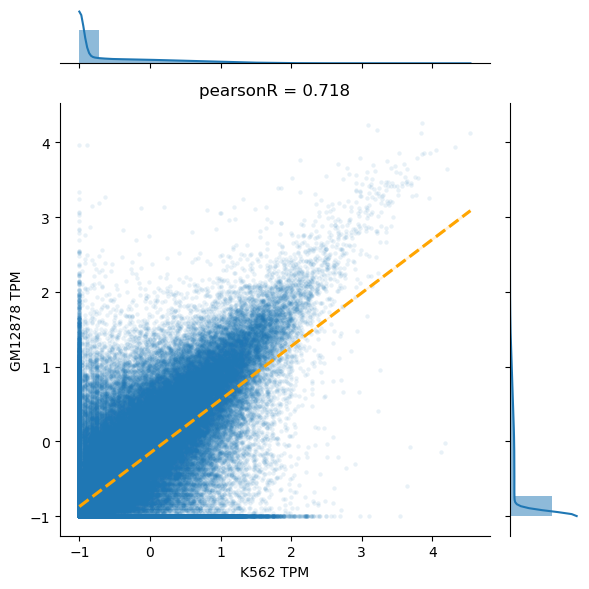

In [51]:
# get boxplot for K562 TPM distribution and GM12878 TPM distribution
transcript_data_GM12878['TPM'] = np.log10(transcript_data_GM12878['TPM'] + 0.1)
transcript_data_K562['TPM'] = np.log10(transcript_data_K562['TPM'] + 0.1)

transcript_data_GM12878['source'] = 'GM12878'
transcript_data_K562['source'] = 'K562'

transcript_data_combined = pd.DataFrame({
    'K562': transcript_data_K562['TPM'],
    'GM12878': transcript_data_GM12878['TPM'],
})

# remove na
transcript_data_combined = transcript_data_combined.dropna(axis=0, how='any')


pearson_r = stats.pearsonr(transcript_data_combined['K562'], transcript_data_combined['GM12878'])
plt.figure(figsize=(6,6))
ax = sns.jointplot(
    data=transcript_data_combined,
    x="K562",
    y="GM12878",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearson_r.statistic))
plt.ylabel('GM12878 TPM')
plt.xlabel('K562 TPM')
plt.tight_layout()

In [63]:
se_events = pd.read_csv('data/transcript_SE.psi', sep="\t", skiprows=1, header=None, names=['event', 'k562_psi', 'gm12878_psi'])

def parse_event(event):
    gene_id, coords = event.split(';')
    event_type, chrom, exon1, exon2, strand = coords.split(':')
    return pd.Series({
        'gene_id': gene_id,
        'event_type': event_type,
        'chrom': chrom,
        'exon1': exon1,
        'exon2': exon2,
        'strand': strand
    })

parsed_events = se_events['event'].apply(parse_event)

se_events = pd.concat([se_events, parsed_events], axis=1)
se_events

,event,k562_psi,gm12878_psi,gene_id,event_type,chrom,exon1,exon2,strand
0,ENSG00000000419.12;SE:chr20:50940933-50941129:...,0.118321,0.029762,ENSG00000000419.12,SE,chr20,50940933-50941129,50941209-50942031,-
1,ENSG00000000457.13;SE:chr1:169854964-169855796...,0.785425,0.670407,ENSG00000000457.13,SE,chr1,169854964-169855796,169855957-169859041,-
2,ENSG00000000460.16;SE:chr1:169798958-169800883...,0.938394,0.819506,ENSG00000000460.16,SE,chr1,169798958-169800883,169800971-169802621,+
3,ENSG00000000460.16;SE:chr1:169806088-169807791...,0.510837,0.757184,ENSG00000000460.16,SE,chr1,169806088-169807791,169807929-169821679,+
4,ENSG00000000971.15;SE:chr1:196676065-196677476...,0.997132,NaN,ENSG00000000971.15,SE,chr1,196676065-196677476,196677667-196679623,+
...,...,...,...,...,...,...,...,...,...
14972,ENSG00000285043.1;SE:chr16:30053499-30054784:3...,0.938144,1.000000,ENSG00000285043.1,SE,chr16,30053499-30054784,30054927-30055172,+
14973,ENSG00000285258.1;SE:chr3:63864999-63873749:63...,0.000000,0.000000,ENSG00000285258.1,SE,chr3,63864999-63873749,63873846-63898399,+
14974,ENSG00000285437.1;SE:chr7:102567083-102568010:...,0.824596,0.132404,ENSG00000285437.1,SE,chr7,102567083-102568010,102568184-102569835,-
14975,ENSG00000285551.1;SE:chr10:62654930-62655367:6...,NaN,1.000000,ENSG00000285551.1,SE,chr10,62654930-62655367,62655631-62656396,+


In [64]:
# print number of events
print("Number of SE events:", se_events.shape[0])
# print number of unique genes
print("Number of unique genes:", se_events['gene_id'].nunique())


# print how many nan values we have in the psi column
print("Number of NaN values in K562 PSI:", se_events['k562_psi'].isna().sum(), "in GM12878 PSI", se_events['gm12878_psi'].isna().sum())
print("Coverage in GM12878 PSI:", se_events['k562_psi'].notna().mean(), "GM12878 PSI:", se_events['gm12878_psi'].notna().mean())

Number of SE events: 14977
Number of unique genes: 7916
Number of NaN values in K562 PSI: 3226 in GM12878 PSI 3263
Coverage in GM12878 PSI: 0.7846030580223009 GM12878 PSI: 0.7821326033250985


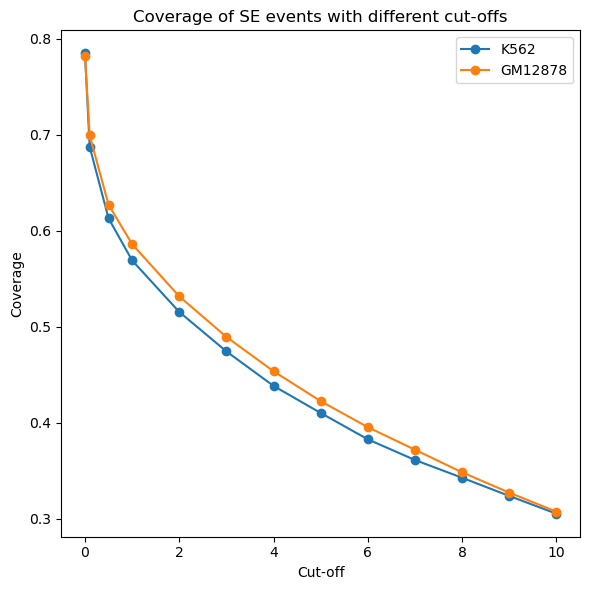

In [69]:
cut_offs = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k562_coverages = []
gm12878_coverages = []

for cut_off in cut_offs:
    cut_se_events = pd.read_csv(f'data/SE_events_tpm_filtered/transcript_SE_f{cut_off}.psi', sep="\t", skiprows=1, 
                            header=None, names=['event', 'k562_psi', 'gm12878_psi'])
    k_coverage = cut_se_events['k562_psi'].notna().mean()
    gm_coverage = cut_se_events['gm12878_psi'].notna().mean()
    k562_coverages.append(k_coverage)
    gm12878_coverages.append(gm_coverage)

plt.figure(figsize=(6,6))
plt.plot(cut_offs, k562_coverages, label='K562', marker='o')
plt.plot(cut_offs, gm12878_coverages, label='GM12878', marker='o')
plt.xlabel('Cut-off')
plt.ylabel('Coverage')
plt.title('Coverage of SE events with different cut-offs')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

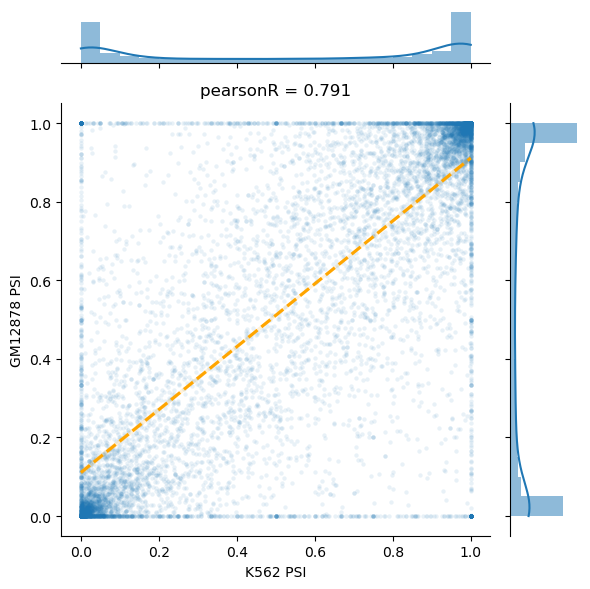

In [66]:
# drop lines where either gm12878_psi or k562_psi is NaN
combined_psi_values = se_events[['k562_psi', 'gm12878_psi']].dropna(axis=0, how='any')


pearson_r = stats.pearsonr(combined_psi_values['k562_psi'], combined_psi_values['gm12878_psi'])
plt.figure(figsize=(6,6))
ax = sns.jointplot(
    data=combined_psi_values,
    x="k562_psi",
    y="gm12878_psi",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearson_r.statistic))
plt.ylabel('GM12878 PSI')
plt.xlabel('K562 PSI')
plt.tight_layout()


In [55]:
# count how many values are 0, and how many are 1, how many are in between
print("Number of 0 values in K562 PSI:", (se_events_k562['psi'] == 0).sum())
print("Number of 1 values in K562 PSI:", (se_events_k562['psi'] == 1).sum())
print("Number of between 0 and 1 values in K562 PSI:", ((se_events_k562['psi'] > 0) & (se_events_k562['psi'] < 1)).sum())


Number of 0 values in K562 PSI: 4971
Number of 1 values in K562 PSI: 4113
Number of between 0 and 1 values in K562 PSI: 22723
